# Deepwalk performance on hetionet alone

read each feature set and test set in linear order

calculate the roc values and save


after all done:
    draw graph

In [1]:
import pandas as pd
import numpy as np

from tqdm import tqdm

from scipy import interp
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve

from sklearn.linear_model import LogisticRegression

from glob import glob
import os
import seaborn as sns

In [2]:
%matplotlib inline

---

if no embedding for training data


In [3]:
def add_features(df, features, mergetype):
    return (df
        .merge(
            features, how=mergetype, left_on="chemical_uid", right_on="uid"
        )
        .drop("uid", axis=1)
        .merge(
            features, how=mergetype, left_on="disease_uid", right_on="uid"
        )
        .drop("uid", axis=1)
    )

def convolv_features(df, features, vecsize, mergetype):
    reg = add_features(df, features, mergetype)
    
    # do multiply and get rid of old features
    for i in range(vecsize):
        reg["conv{}".format(i)] = reg["f{}_x".format(i)] * reg["f{}_y".format(i)]

    reg = (reg
        .drop(
            ["f{}_x".format(i) for i in range(vecsize)], axis=1
        )
        .drop(
            ["f{}_y".format(i) for i in range(vecsize)], axis=1
        )
    )
        
    return reg

there are nodes in the holdout dataset that did not have any embeddings generated for it. check to see if they had proper adjlists made

In [4]:
def eval_performance(fbase, K, vecsize):
    for idx in range(K):
        train = pd.read_csv(
            "tmp/data/train/{}_train_{}.tsv".format(fbase, idx),
            sep='\t'
        )
        
        holdout = pd.read_csv(
            "tmp/data/holdout/{}_holdout_{}.tsv".format(fbase, idx),
            sep='\t'
        )

        features = pd.read_csv(
            "tmp/data/embeddings/{}_embedding_{}.txt".format(fbase, idx),
            sep=" ", skiprows=1,
            names=["uid"] + ["f{}".format(i) for i in range(vecsize)]
        )

        tmp = convolv_features(train, features, vecsize, "inner")

        feat_cols = ["conv{}".format(j) for j in range(vecsize)]
        regmodel = LogisticRegression(C=1e9).fit(tmp[feat_cols], tmp["etype"])

        # test on holdout
        test = convolv_features(
            holdout.drop("etype", axis=1),
            features, vecsize, "left"
        )
        
        assert len(test) == len(holdout)
        
        # if there are empty ones in the features column,
        # then we didn't generate any embeddings, and therefore
        # need to split those up and treat as zeroes
        # for the others we can predict normally, then join together
        
        regular = test[test["conv0"].notnull()].assign(missed = False)
        
        missed = (test[test["conv0"].isnull()]
            .assign(
                predval = 0
            )
            .assign(missed = True)
        )
                
        # add in predictions
        ans = regular.assign(
            predval = lambda df: regmodel.predict_proba(df[feat_cols])[:, 1]
        )
        
        ans = ans.append(missed)
        
        assert len(ans) == len(holdout)
        
        yield (ans
            [["chemical_uid", "disease_uid", "predval", "missed"]]
            .merge(
                holdout[["chemical_uid", "disease_uid", "etype"]],
                how="inner", on=["chemical_uid", "disease_uid"]
            )
            .sort_values("predval", ascending=False)
            .reset_index(drop=True)
        )

In [5]:
def finished(fbase, K):
    for i in range(K):
        ename = "tmp/data/embeddings/{}_embedding_{}.txt".format(fbase, i)
        
        if not os.path.isfile(ename):
            return False

    return True

need to check that we have the expected embeddings for the concepts

In [6]:
vecsize = 128

missed = []
for edge_fname in tqdm(glob("tmp/edges/*.tsv")):
    fbase = edge_fname.split("/")[2][:-4]
    
    K = 5
    
    # check if all K embeddings are done
    if finished(fbase, K):

        aucs = []
        for res in eval_performance(fbase, K, vecsize):
            fpr, tpr, thresh = roc_curve(res["etype"], res["predval"])

            auc_val = auc(fpr, tpr)
            aucs.append(auc_val)
            
            missed.append((res["missed"].sum(), len(res), len(res.query("missed and etype == 1"))))

        temp = (pd
            .Series(aucs)
            .to_frame("auc_roc")
            .assign(edge_val = fbase)
        )
        
        temp.to_csv(
            "tmp/results/{}.tsv".format(fbase), sep='\t', index=False
        )

100%|██████████| 1/1 [00:14<00:00, 14.48s/it]


---

In [7]:
mdata = pd.DataFrame(missed, columns=["num_missed", "total", "missed_and_true"])

In [8]:
mdata.shape

(5, 3)

In [9]:
mdata.head()

,num_missed,total,missed_and_true
0,13112,94014,44
1,10864,92628,34
2,16143,92081,66
3,7716,84960,31
4,14008,91068,48


In [10]:
mdata.sort_values("missed_and_true", ascending=False).head(10)

,num_missed,total,missed_and_true
2,16143,92081,66
4,14008,91068,48
0,13112,94014,44
1,10864,92628,34
3,7716,84960,31


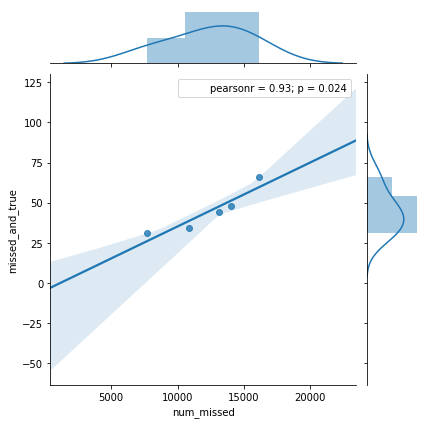

In [11]:
sns.jointplot(data=mdata, x="num_missed", y="missed_and_true", kind="reg")

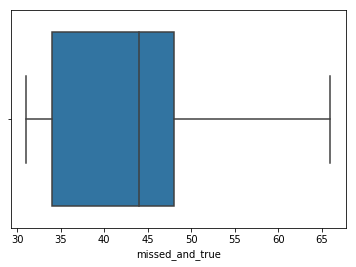

In [12]:
sns.boxplot(mdata["missed_and_true"])

---

In [13]:
res = [
    pd.read_csv(fname, sep='\t')
    for fname in glob("tmp/results/*.tsv")
]

res = pd.concat(res)

In [14]:
res.shape

(5, 2)

In [15]:
res.head()

,auc_roc,edge_val
0,0.861440,no_drug_gene_or_drug_disease
1,0.872229,no_drug_gene_or_drug_disease
2,0.839946,no_drug_gene_or_drug_disease
3,0.882665,no_drug_gene_or_drug_disease
4,0.864650,no_drug_gene_or_drug_disease


In [16]:
res["auc_roc"].mean()

0.86418598994982521

i must be doing something wrong with these removal experiments because we are still getting higher than normal ROC numbers after removal of two edges that we think should definitely kill the performance

---

In [17]:
# original deepwalk performance on unmodified hetionet
orig = [0.83794169828897624,
 0.83592900230751011,
 0.82794024342944517,
 0.83258454954099403,
 0.84911988472878375,
 0.82679078477519785,
 0.86955409367485537,
 0.81721305005383327,
 0.82568604664477641,
 0.85703519382275861]

In [18]:
hetio_perf = (pd
    .Series(orig)
    .to_frame("auc_roc")
    .assign(pct_kept = 100)
)

In [19]:
hetio_perf.head()

,auc_roc,pct_kept
0,0.837942,100
1,0.835929,100
2,0.827940,100
3,0.832585,100
4,0.849120,100


In [20]:
hetio_perf["auc_roc"].mean()

0.8379794547267132